## Performing an Error Mitigation Workflow with mitiq on Amazon Braket (Advanced)

In this notebook, we will show how we can use the previous three methodologies, namely readout error mitigation, Pauli twirling, and Zero-noise extrapolation, in conjunction with ProgramSets in an applied quantum simulation example. 

We will start with an emulator, build the workflow, and then in the next notebook, apply it to a real system. 

### Installing mitiq
>[!WARNING]
>mitiq is not included by default with `amazon-braket-examples` requirements or in the Amazon Braket Notebook Instances. To install, uncomment the first line in the next code block, and restart the notebook. Or run install from `extra/requirement-mitiq.txt`. 

Mitiq utilizes Cirq as the backend, and may represent circuits using their representation. 

In [ ]:
# !pip install mitiq

try:
    import mitiq  # noqa: F401
    print("Package 'mitiq' is installed.")
except ImportError:
    print("!! Package 'mitiq' is not installed !!")

Package 'mitiq' is installed.


### Overview

The underlying rationale of using ZNE, PT, and REM, is that while ZNE will extrapolate over a continuous noise parameter, measurement errors are often orders of magnitude larger, and generally will not be considered in a simple extrapolation scheme. Thus, PT can normalize noise, REM will correct differences from measurement, and ZNE will help to extrapolate the noise within the circuit. This workflow, sometimes coupled with digital dynamical coupling,  is present in some other common error mitigation workflows (see the [mitiq Advanced Error Mitigation Pipeline](https://mitiq.readthedocs.io/en/stable/examples/advanced_error_mitigation_pipeline.html) or through [Qiskit Runtime](https://github.com/Qiskit/samplomatic/issues)). 

This workflow can generally be applied to many problems of observable estimation. A more thorough treatment of each layer using layer-wise Richardson extrapolation (see the second notebook) may help as well. 

To coordinate our error mitigation pipeline, we will utilize some prebuilt functions for distributing circuits to ProgramSets in `tools/program_set_tools.py`. Let's begin by importing relevant functions. 

In [2]:
import os
import sys
from functools import partial, reduce

import numpy as np
from mitiq.pt import generate_pauli_twirl_variants
from mitiq.rem import generate_inverse_confusion_matrix
from mitiq.zne import ExpFactory, combine_results, construct_circuits
from mitiq_braket_tools import braket_rem_twirl_mitigator

from braket.circuits import Circuit
from braket.parametric import FreeParameter
from braket.quantum_information import PauliString

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # parent  

from tools.mitigation_tools import apply_readout_twirl, get_twirled_readout_dist
from tools.noise_models import qd_total
from tools.observable_tools import pauli_grouping
from tools.program_set_tools import run_with_program_sets

np.set_printoptions(precision=3, linewidth=500, suppress=True)


Now we define our problem Hamiltonian, here a simple Ising Hamiltonian. For simplicity, we use a simple string representation of the Pauli operators, and a greedy color-based grouping scheme using networkx. 

In [3]:
def ising_hamiltonian(
        hopping : float, 
        self_interaction : float, 
        num_qubits : int):
    hamiltonian = []
    n = num_qubits
    for i in range(num_qubits):
        hamiltonian.append(
            (self_interaction,i*"I"+"Z"+(n-i-1)*"I")
            )
        if i>0:
            hamiltonian.append(
                (hopping, (i-1)*"I"+"XX"+(n-i-1)*"I"))
    return hamiltonian

num_qubits = 6

## UNCOMMENT_TO_RUN
num_qubits = 2

dim = 2**num_qubits
ham = ising_hamiltonian(0.5,1,num_qubits)
matrix = reduce(np.add,[c*(PauliString(p).to_unsigned_observable(include_trivial=True).to_matrix()) for c,p in ham])
bases, pauli_terms = pauli_grouping(ising_hamiltonian(0.5,1,num_qubits))

# print(bases)
print(f'number of distinct measurement bases: {len(bases)}') 
print(bases)
print(pauli_terms)


number of distinct measurement bases: 2
['XX', 'ZZ']
[[(0.5, 'XX')], [(1, 'ZI'), (1, 'IZ')]]


Now, we derive a test circuit, which we will parameterize with 2 parameters. 

In [4]:
def test_circuit(
        theta1 : FreeParameter,
        theta2 : FreeParameter,
        num_qubits : int):
    circ = Circuit()
    for i in range(num_qubits):
        circ.rx(i,theta1)
    for i in range(0,num_qubits-1,2):
        circ.cz(i,i+1)
    for i in range(num_qubits):
        circ.rx(i,theta2)        
    for i in range(1,num_qubits-1,2):
        circ.cz(i,i+1)
    return circ

alp = FreeParameter("alp")
bet = FreeParameter("bet")

ansatz = test_circuit(alp, bet, num_qubits)
print(ansatz)

T  : │     0     │  1  │     2     │
      ┌─────────┐       ┌─────────┐ 
q0 : ─┤ Rx(alp) ├───●───┤ Rx(bet) ├─
      └─────────┘   │   └─────────┘ 
      ┌─────────┐ ┌─┴─┐ ┌─────────┐ 
q1 : ─┤ Rx(alp) ├─┤ Z ├─┤ Rx(bet) ├─
      └─────────┘ └───┘ └─────────┘ 
T  : │     0     │  1  │     2     │

Unassigned parameters: [alp, bet].


Here we define our parameters for our system and subseqeunt error mitigation. The estimated number of circuits will be naively $N_{ZNE} * N_{para} * N_{twirls} * N_{bases} + N_{REM}$. Explicitly, this is `len(scale_factors) * num_twirls * len(parameters) * len(bases) + rem_twirls`. 

`shot_per_base` here refers to each function evaluation, and naively is distributed according to each observable basis. Overhead is actually that, the multiplicative factor that we will increase by. It can match the REM overhead or potentially exceed it, though there are limits to which we trust the reliability of it.  

In [5]:
from math import ceil

shot_per_base = 10000
overhead = 4
scale_factors = [1,3,7]
num_twirls = 25
rem_twirls = 100

## UNCOMMENT_TO_RUN
rem_twirls = 2
num_twirls = 2

rem_overhead = 4 # don't let this be too large

parameters = [{"alp":0.0, "bet":0.0}]

total_number_of_circuits = len(scale_factors) * num_twirls * len(parameters) * len(bases) + rem_twirls
total_shots = shot_per_base * overhead * len(scale_factors) * len(bases) + shot_per_base * rem_overhead
print(f"total number of circuits: {total_number_of_circuits}")
print(f"-- task cost reduced from ${total_number_of_circuits*0.3:.2f} to ${0.3*(ceil(total_number_of_circuits/100)):.2f}")
print(f"total number of shots: {total_shots}")
print(f"-- total shot range (SC devices): ${total_shots * 0.0009:.2f} <-> ${total_shots * 0.0016:.2f}")

total number of circuits: 14
-- task cost reduced from $4.20 to $0.30
total number of shots: 280000
-- total shot range (SC devices): $252.00 <-> $448.00


> [!IMPORTANT]
> While ProgramSets greatly reduce the task cost, the shot cost can be further reduced in a number of ways. We have explored this in previous notebooks, but one should consider (1) the least resolved significant mitigation, (2) shot allocation strategies for observables and (if possible) extrapolations, and (3) 

### Error Mitigation Workflow

#### Setting up the circuits 

Now we begin the workflow! The key utility is a function called `run_with_program_sets`. The basic idea is that this can take lists or numpy.ndarrays of inputs for circuits, parameters, and observable (specifically, the union of bases), distribute them to ProgramSets, and return back either distributions or the calculated expectations. 

We begin take our circuit `target_circuit`, and then (1) construct the ZNE variants and (2) on top of each of those twirl the gates. Then we apply a readout twirl to each circuits. For the mitiq twirling converter, we do need to bind parameters prior to twirling, but that is okay. 

In [6]:
target_circuit = ansatz.make_bound_circuit(parameters[0])


circuits = np.array([
    generate_pauli_twirl_variants(c, num_circuits=num_twirls) \
        for c in construct_circuits(target_circuit, scale_factors=scale_factors)
    ], 
    dtype=object)

circuits, twirls =  apply_readout_twirl(circuits)

print(circuits.shape)


(3, 2)


In [7]:
print(circuits[0,0])

T  : │     0      │  1  │  2  │  3  │     4      │  5  │
      ┌──────────┐ ┌───┐       ┌───┐ ┌──────────┐ ┌───┐ 
q0 : ─┤ Rx(0.00) ├─┤ Z ├───●───┤ I ├─┤ Rx(0.00) ├─┤ Y ├─
      └──────────┘ └───┘   │   └───┘ └──────────┘ └───┘ 
      ┌──────────┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌──────────┐ ┌───┐ 
q1 : ─┤ Rx(0.00) ├─┤ X ├─┤ Z ├─┤ X ├─┤ Rx(0.00) ├─┤ I ├─
      └──────────┘ └───┘ └───┘ └───┘ └──────────┘ └───┘ 
T  : │     0      │  1  │  2  │  3  │     4      │  5  │


Note the output is a 3 by 25 -> the are permutations of (ZNE, twirls).

#### Readout Twirling (in-depth)

For our readout mitigation, we need to supply a post-processing function. From the previous notebook on twirling, we can see that based on the twirled gate, we can effectively apply a bit-mask to transform the result to the appropriate POVM basis. 

Within a workflow, we allow for simple post processing of results. Because we have included this bitmask, we need to convey the proper direction of flips. Thus, we build this hear, casting the `twirl` object to the final results object.

We have this automated within 

In [8]:
bit_masks = np.zeros(twirls.shape + (1, len(bases)), dtype=object)
for n,i in np.ndenumerate(twirls):
    for m,b in enumerate(bases):
        new = []
        for twirl,base in zip(b, i):
            if base == "I":
                base == "Z"
            if twirl == base or twirl=="I" or base == "I":
                new.append("0")
            else:
                new.append("1")
        bit_masks[n + (0,m)] = "".join(new)
print(bit_masks.shape)
print(twirls[0,:].T)
print(bit_masks[0,:,0,:].T)


(3, 2, 1, 2)
['YI' 'ZY']
[['10' '11']
 ['10' '01']]


One can confirm that the twirling element correctly corresponds to an all Z measurement in the first row, and an all X measurement in the second row.  

#### Execution Step 1 - Readout Calibration

`get_twirled_readout_dist` will perform the REM technique described previously, and return the bit flip distribution. From that, we can construct a single-qubit RO errors, and then use `mitiq` to construct the inverse confusion matrix. 

The final step is to get a post-processing function, `measurement_filter`, which behind-the-scenes will apply the mitiq.rem functions as well as undo the measurement Pauli twirl. 

In [9]:
dist = get_twirled_readout_dist(range(num_qubits),rem_twirls, shots = rem_overhead * shot_per_base, device = qd_total)

cm = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        cm[i, j] = dist.get(bin(i^j)[2:].zfill(num_qubits), 0)

qubit_errors = [0] * num_qubits
for k,v in dist.items():
    for n in range(num_qubits):
        if k[n]=="1":
            qubit_errors[n]+= v
print('single qubit readout errors')
print(qubit_errors)
mats = [generate_inverse_confusion_matrix(1,p0=i,p1=i) for i in qubit_errors]
icm = reduce(np.kron, mats, np.array([[1]]))

measurement_filter = braket_rem_twirl_mitigator(
    icm, bit_masks=bit_masks
)


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/default_simulator/simulator.py:333: UserWarning: You are running a noise-free circuit on the density matrix simulator. Consider running this circuit on the state vector simulator: LocalSimulator("default") for a better user experience.
  warnings.warn(


BASE:  {'00': 1.0}
single qubit readout errors
[0, 0]


#### Execution Step 2 - Main Execution

In [ ]:
result = run_with_program_sets(
    circuits, bases, pauli_terms, parameters = [{}], device = qd_total,
    measurement_filter = measurement_filter, 
    shots_per_executable = shot_per_base * overhead // num_twirls)

# the output of test is a dim_circ + dim_para + dim_bases, which is (N_zne, N_twirl), (1,) and (N_bases,) respectively
print(result.shape)

And now for some post-processing: 

In [11]:
# print(noisy_base)
# first sum over the observables 
twirled = np.sum(result, axis=(2,3))
print(twirled.T)
# then, average over the twirls 
zne_results = np.sum(twirled, axis = (1)) / num_twirls
print(zne_results)

method = partial(ExpFactory.extrapolate, asymptote = 0)
mitigated = combine_results(scale_factors=scale_factors, results = zne_results, extrapolation_method=method)

jackknife = []
for i in range(num_twirls):
    temp = np.sum(twirled.T[:i,:],axis=0) + np.sum(twirled.T[i+1:,:], axis = 0)
    temp = temp / (num_twirls - 1)
    jackknife.append(combine_results(scale_factors=scale_factors, results = temp, extrapolation_method=method))
print(np.average(jackknife), np.std(jackknife))
print(f'jackknife estimate: {np.average(jackknife)}, std: {np.sqrt(np.sum(np.square(np.array(jackknife)-np.average(jackknife)))*(num_twirls-1)/num_twirls**2)}')
mitigated = combine_results(scale_factors=scale_factors, results = zne_results, extrapolation_method=method)
# extra_tail = combine_results(scale_factors=scale_factors + [100], results = zne_results.tolist() + [0,], extrapolation_method=RichardsonFactory.extrapolate)


[[1.687 1.568 0.996]
 [1.645 1.458 1.113]]
[1.666 1.513 1.055]
1.840501490523812 0.07797366883826184
jackknife estimate: 1.840501490523812, std: 0.05513570998952914


For comparison, we can run these as well (note these are not all accounted for in our budget before), and we could retrieve the probability distribution ourselves and perform all the post processing to save some compute time.  

In [ ]:
ans_111 = mitigated
ans_110 = zne_results[0]

noisy_base = run_with_program_sets(
    construct_circuits(target_circuit, scale_factors=scale_factors), 
    bases, 
    pauli_terms,
    parameters=[{}],
    device = qd_total,
    shots_per_executable= shot_per_base) # no twirls! 

noisy_base = np.sum(noisy_base, axis = (1,2))
print(noisy_base)
ans_000 = noisy_base[0]
ans_001 = combine_results(scale_factors=scale_factors, results = noisy_base, extrapolation_method=method)

print('obtained REM+twirl-free results')

circuits_no_rem = np.array([
    generate_pauli_twirl_variants(c, num_circuits=num_twirls) \
        for c in construct_circuits(target_circuit, scale_factors=scale_factors)
    ], 
    dtype=object)


noisy_twirl = run_with_program_sets( # no measurement filter
    circuits_no_rem, bases, pauli_terms, parameters = [{}], device = qd_total,
    shots_per_executable = shot_per_base * overhead // num_twirls)

noisy_twirl = np.sum(noisy_twirl, axis=(1,2,3)) / num_twirls
print(noisy_twirl)

ans_010 = noisy_twirl[0]
ans_011 = combine_results(scale_factors=scale_factors, results = noisy_twirl, extrapolation_method=method)
# no twirls 

print('obtained REM free results')
mod_measurement_filter = braket_rem_twirl_mitigator(
    icm, bit_masks=bit_masks[:,0,:,:] # just the first twirl
)
print(mod_measurement_filter)

noisy_rem  = run_with_program_sets(
    circuits[:,0], bases, pauli_terms, parameters = [{}], device = qd_total,
    measurement_filter = mod_measurement_filter, 
    shots_per_executable =( shot_per_base * overhead) // num_twirls)

noisy_rem = np.sum(noisy_rem, axis=(1, 2))
print(noisy_rem)
ans_100 = noisy_rem[0]
ans_101 = combine_results(scale_factors=scale_factors, results = noisy_rem, extrapolation_method=method)

print('obtained twirl-free results')


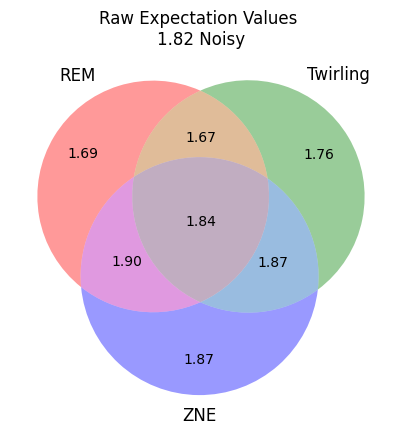

In [13]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

plt.title(f"Raw Expectation Values \n{ans_000:.2f} Noisy")

venn3(subsets = (ans_100, ans_010, ans_110, ans_001, ans_101, ans_011, ans_111), set_labels= ("REM", "Twirling", "ZNE"),
      subset_label_formatter= lambda x : f"{x:.2f}")

In [15]:


statevector = target_circuit.to_unitary()[:,0]
statevector = statevector.reshape((dim,1))
ideal = (np.conj(statevector).T @ matrix @ statevector)[0,0]
print(f"Ideal Expectation: {ideal.real}")

delta = abs(ans_000 - ideal)


improv = [round(delta/abs(a-ideal),2) for a in [ans_100, ans_010, ans_110, ans_001, ans_101, ans_011, ans_111]]
reduct = [1 - abs(a-ideal)/delta for a in [ans_100, ans_010, ans_110, ans_001, ans_101, ans_011, ans_111]]
improv_labels = {k:v for k,v in zip([1.000,1.001, 1.002, 1.003, 1.004, 1.005, 1.006],improv )}
reduct_labels = {k:v for k,v in zip([1.000, 1.001, 1.002, 1.003, 1.004, 1.005, 1.006], reduct)}

def func_improv(x):
    return f"{improv_labels[x]:.2f}x"

def func_reduct(x):
    return f"{(100*reduct_labels[x]):.2f}%"

print(reduct)
print(improv)

Ideal Expectation: 2.0
[-0.740566037735851, -0.3283851276359602, -0.8543285238623757, 0.29634007924111727, 0.4478809085265322, 0.30172853582661374, 0.10487426469839056]
[0.57, 0.75, 0.54, 1.42, 1.81, 1.43, 1.12]


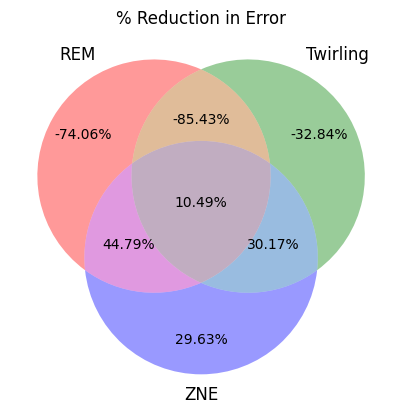

In [16]:
plt.title(r"% Reduction in Error")
venn3(
    subsets = tuple(reduct_labels.keys()),
       set_labels= ("REM", "Twirling", "ZNE"),
       subset_label_formatter= func_reduct,)


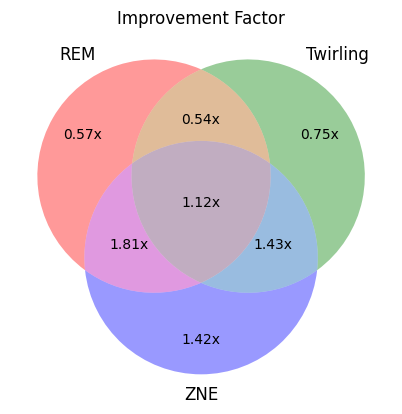

In [17]:
plt.title(r"Improvement Factor")

venn3(
    subsets = tuple(improv_labels.keys()),
       set_labels= ("REM", "Twirling", "ZNE"),
       subset_label_formatter= func_improv)

Here we see in isolation, each method does well to improve the answer, but the closest by far is the combination of all methods, where we see substantial improvement in the quality of the result. 

>[!NOTE]
> Using a depolarizing model will result in REM + ZNE yielding similar errors to REM + Twirl + ZNE. On today's devices we do not always expect for normalized noise models, and so the depolarizing model is not realistic. 

### Conclusion

In summary, in this notebook we explored tools for conducting a full error mitigation workflow for a problem of interest using ***mitiq*** with Amazon Braket ProgramSets. For our example, we how combining error mitigation approaches can be challenging, but can greatly improve the quality of the results. 

Importantly, this is carried out with a 83-times reduction in the submission costs, expected faster executions, and orders of magnitude improvement in the outcome for a simulated noise model. 


### References